# Duolingo Learner Return Prediction Analysis

## Question: What behavioral factors predict whether a learner returns the next day?

This notebook performs comprehensive analysis of Duolingo learner behavioral data to identify key factors that predict daily return behavior, including:
- Exploratory data analysis of behavioral features
- Statistical analysis of predictors
- Predictive modeling with feature importance
- Visualizations and actionable insights


## 1. Setup & Imports


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Statistical analysis
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print("Libraries imported successfully!")
print(f"Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


Libraries imported successfully!
Analysis date: 2025-11-23 04:13:34


## 2. Data Loading & Initial Exploration


In [2]:
# Load the dataset
df = pd.read_csv('duolingo_behavior_simulated_dataset.csv')

print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nColumn names: {list(df.columns)}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nFirst few rows:")
df.head()


DATASET OVERVIEW
Shape: 225,000 rows × 19 columns

Column names: ['user_id', 'date', 'learning_language', 'mobile_os', 'lessons_completed', 'time_spent_minutes', 'xp_earned', 'mistakes_made', 'used_hints', 'sessions', 'session_time_block', 'streak_length', 'league', 'received_notification', 'opened_notification', 'has_friends', 'competed_in_league', 'used_gems', 'returned_next_day']

Data types:
user_id                  object
date                     object
learning_language        object
mobile_os                object
lessons_completed         int64
time_spent_minutes        int64
xp_earned                 int64
mistakes_made             int64
used_hints                int64
sessions                  int64
session_time_block       object
streak_length             int64
league                   object
received_notification     int64
opened_notification       int64
has_friends               int64
competed_in_league        int64
used_gems                 int64
returned_next_day        

,user_id,date,learning_language,mobile_os,lessons_completed,time_spent_minutes,xp_earned,mistakes_made,used_hints,sessions,session_time_block,streak_length,league,received_notification,opened_notification,has_friends,competed_in_league,used_gems,returned_next_day
0,user_1,2025-01-01,German,iOS,2,19,28,2,0,2,Morning,1,Ruby,1,1,0,0,0,0
1,user_1,2025-01-02,German,iOS,1,19,19,0,0,3,Morning,2,Bronze,1,1,0,1,0,0
2,user_1,2025-01-03,German,iOS,1,4,19,2,0,2,Afternoon,3,Bronze,1,1,0,1,0,0
3,user_1,2025-01-04,German,iOS,0,23,0,1,0,2,Afternoon,0,Silver,1,0,0,0,0,0
4,user_1,2025-01-05,German,iOS,3,27,54,4,0,1,Morning,1,Silver,1,1,0,0,0,0


In [3]:
# Basic statistics and data quality check
print("=" * 60)
print("DATA QUALITY CHECK")
print("=" * 60)
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nDuplicate rows: {df.duplicated().sum()}")
print(f"\nSummary statistics:")
df.describe()


DATA QUALITY CHECK

Missing values:
user_id                  0
date                     0
learning_language        0
mobile_os                0
lessons_completed        0
time_spent_minutes       0
xp_earned                0
mistakes_made            0
used_hints               0
sessions                 0
session_time_block       0
streak_length            0
league                   0
received_notification    0
opened_notification      0
has_friends              0
competed_in_league       0
used_gems                0
returned_next_day        0
dtype: int64

Duplicate rows: 0

Summary statistics:


,lessons_completed,time_spent_minutes,xp_earned,mistakes_made,used_hints,sessions,streak_length,received_notification,opened_notification,has_friends,competed_in_league,used_gems,returned_next_day
count,225000.00,225000.00,225000.00,225000.00,225000.00,225000.00,225000.00,225000.00,225000.00,225000.00,225000.00,225000.00,225000.00
mean,1.00,14.52,14.48,1.28,0.30,1.50,1.65,0.70,0.42,0.40,0.20,0.15,0.12
std,1.00,7.03,15.08,1.51,0.46,0.67,2.06,0.46,0.49,0.49,0.40,0.36,0.33
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,10.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,14.00,13.00,1.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00
75%,2.00,19.00,20.00,2.00,1.00,2.00,2.00,1.00,1.00,1.00,0.00,0.00,0.00
max,9.00,60.00,136.00,14.00,1.00,3.00,23.00,1.00,1.00,1.00,1.00,1.00,1.00


In [4]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Check unique values for categorical columns
print("=" * 60)
print("CATEGORICAL VARIABLES")
print("=" * 60)
print(f"\nUnique learning languages: {sorted(df['learning_language'].unique())}")
print(f"\nUnique mobile OS: {sorted(df['mobile_os'].unique())}")
print(f"\nUnique leagues: {sorted(df['league'].unique())}")
print(f"\nUnique session time blocks: {sorted(df['session_time_block'].unique())}")
print(f"\nDate range: {df['date'].min()} to {df['date'].max()}")
print(f"\nNumber of unique users: {df['user_id'].nunique():,}")


CATEGORICAL VARIABLES

Unique learning languages: ['English', 'French', 'German', 'Italian', 'Japanese', 'Spanish']

Unique mobile OS: ['Android', 'Web', 'iOS']

Unique leagues: ['Bronze', 'Gold', 'Ruby', 'Sapphire', 'Silver']

Unique session time blocks: ['Afternoon', 'Evening', 'Late-night', 'Morning']

Date range: 2025-01-01 00:00:00 to 2025-02-14 00:00:00

Number of unique users: 5,000


TARGET VARIABLE: returned_next_day

Return rate: 12.17%

Distribution:
returned_next_day
0    197622
1     27378
Name: count, dtype: int64

Distribution (%):
returned_next_day
0   87.83
1   12.17
Name: proportion, dtype: float64


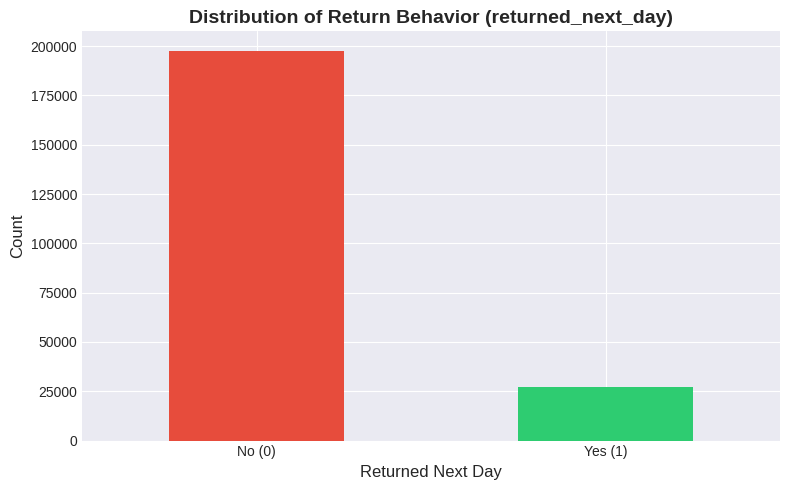

In [5]:
# Target variable analysis
print("=" * 60)
print("TARGET VARIABLE: returned_next_day")
print("=" * 60)
print(f"\nReturn rate: {df['returned_next_day'].mean():.2%}")
print(f"\nDistribution:\n{df['returned_next_day'].value_counts()}")
print(f"\nDistribution (%):\n{df['returned_next_day'].value_counts(normalize=True) * 100}")

# Visualize target distribution
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
df['returned_next_day'].value_counts().plot(kind='bar', ax=ax, color=['#e74c3c', '#2ecc71'])
ax.set_title('Distribution of Return Behavior (returned_next_day)', fontsize=14, fontweight='bold')
ax.set_xlabel('Returned Next Day', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_xticklabels(['No (0)', 'Yes (1)'], rotation=0)
plt.tight_layout()
plt.show()


## 3. Exploratory Data Analysis (EDA)


### 3.1 Return Rate by Segments


RETURN RATE BY LEARNING LANGUAGE
                   Return_Rate  Count
learning_language                    
Italian                   0.12  38115
Japanese                  0.12  37305
Spanish                   0.12  35415
German                    0.12  36675
English                   0.12  38835
French                    0.12  38655


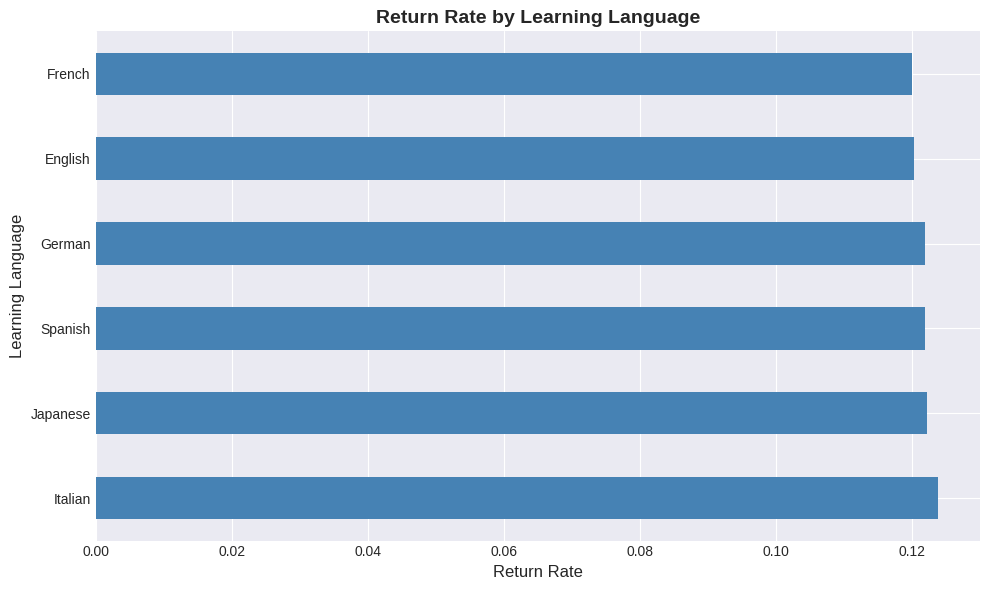

In [6]:
# Return rate by learning language
print("=" * 60)
print("RETURN RATE BY LEARNING LANGUAGE")
print("=" * 60)
lang_return = df.groupby('learning_language')['returned_next_day'].agg(['mean', 'count'])
lang_return.columns = ['Return_Rate', 'Count']
lang_return = lang_return.sort_values('Return_Rate', ascending=False)
print(lang_return)

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
lang_return['Return_Rate'].plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Return Rate by Learning Language', fontsize=14, fontweight='bold')
ax.set_xlabel('Return Rate', fontsize=12)
ax.set_ylabel('Learning Language', fontsize=12)
plt.tight_layout()
plt.show()


RETURN RATE BY MOBILE OS
           Return_Rate  Count
mobile_os                    
Android           0.12  76365
Web               0.12  75060
iOS               0.12  73575


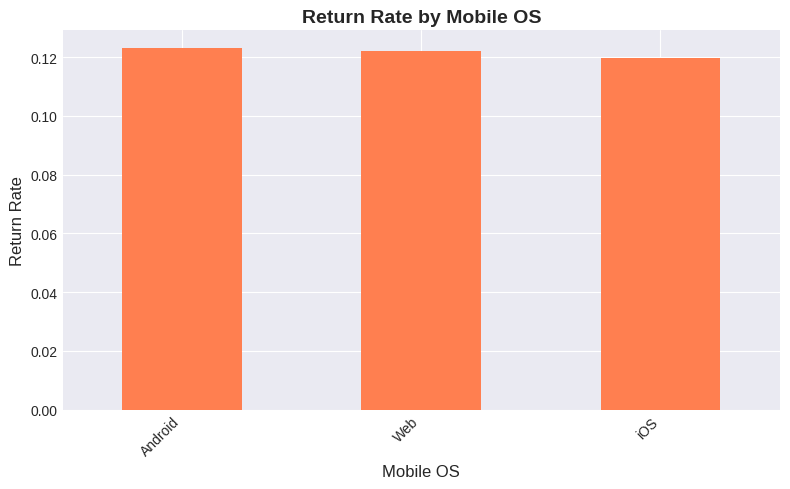

In [7]:
# Return rate by mobile OS
print("=" * 60)
print("RETURN RATE BY MOBILE OS")
print("=" * 60)
os_return = df.groupby('mobile_os')['returned_next_day'].agg(['mean', 'count'])
os_return.columns = ['Return_Rate', 'Count']
os_return = os_return.sort_values('Return_Rate', ascending=False)
print(os_return)

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
os_return['Return_Rate'].plot(kind='bar', ax=ax, color='coral')
ax.set_title('Return Rate by Mobile OS', fontsize=14, fontweight='bold')
ax.set_xlabel('Mobile OS', fontsize=12)
ax.set_ylabel('Return Rate', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


RETURN RATE BY LEAGUE
          Return_Rate  Count
league                      
Ruby             0.12  11291
Sapphire         0.12  33949
Gold             0.12  44916
Silver           0.12  67642
Bronze           0.12  67202


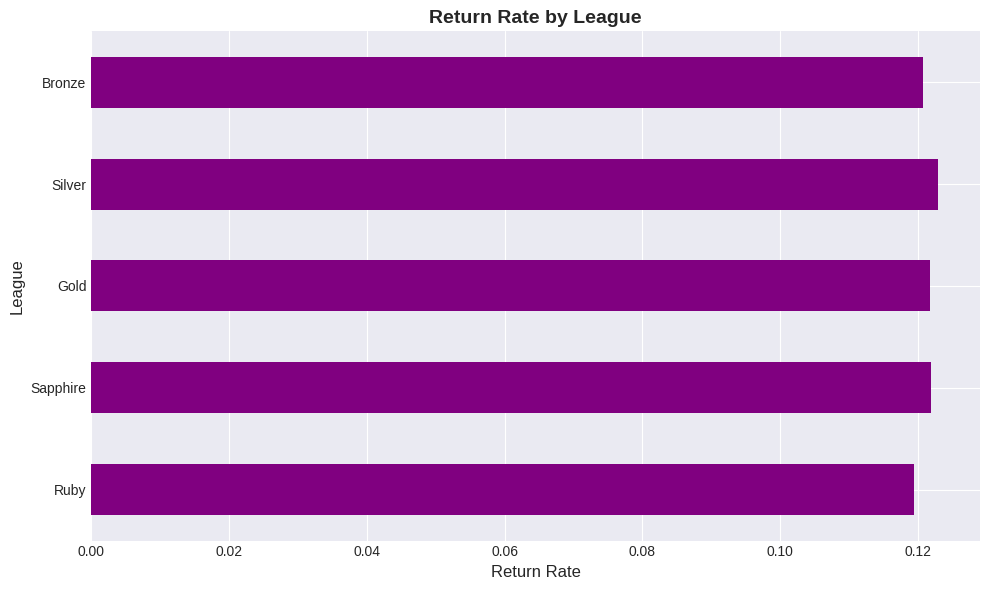

In [8]:
# Return rate by league
print("=" * 60)
print("RETURN RATE BY LEAGUE")
print("=" * 60)
league_order = ['Ruby', 'Sapphire', 'Gold', 'Silver', 'Bronze']
league_return = df.groupby('league')['returned_next_day'].agg(['mean', 'count'])
league_return.columns = ['Return_Rate', 'Count']
league_return = league_return.reindex(league_order)
print(league_return)

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
league_return['Return_Rate'].plot(kind='barh', ax=ax, color='purple')
ax.set_title('Return Rate by League', fontsize=14, fontweight='bold')
ax.set_xlabel('Return Rate', fontsize=12)
ax.set_ylabel('League', fontsize=12)
plt.tight_layout()
plt.show()


RETURN RATE BY SESSION TIME BLOCK
                    Return_Rate  Count
session_time_block                    
Morning                    0.12  56131
Afternoon                  0.12  56390
Evening                    0.12  90019
Late-night                 0.12  22460


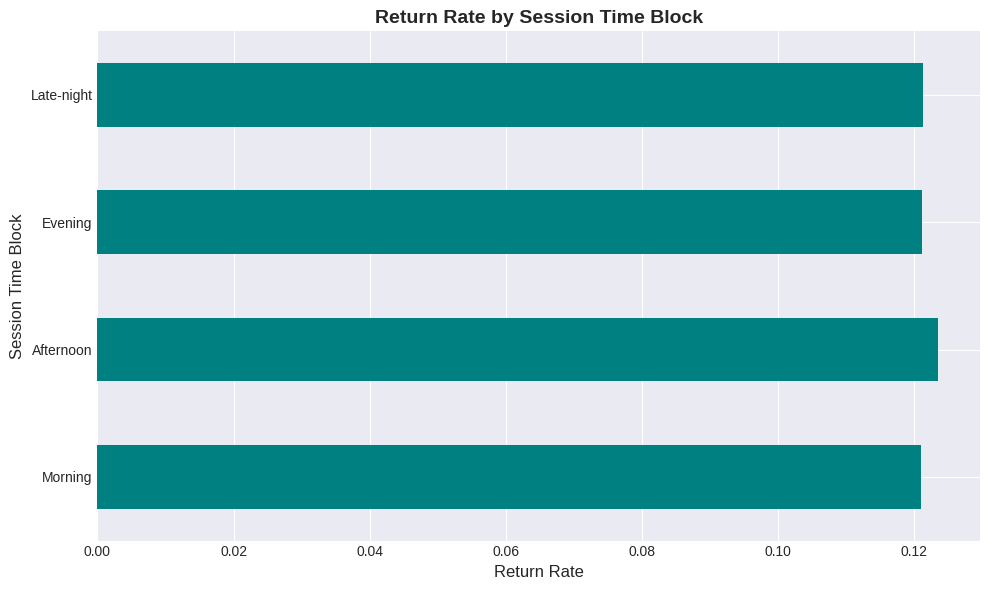

In [9]:
# Return rate by session time block
print("=" * 60)
print("RETURN RATE BY SESSION TIME BLOCK")
print("=" * 60)
time_order = ['Morning', 'Afternoon', 'Evening', 'Late-night']
time_return = df.groupby('session_time_block')['returned_next_day'].agg(['mean', 'count'])
time_return.columns = ['Return_Rate', 'Count']
time_return = time_return.reindex(time_order)
print(time_return)

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
time_return['Return_Rate'].plot(kind='barh', ax=ax, color='teal')
ax.set_title('Return Rate by Session Time Block', fontsize=14, fontweight='bold')
ax.set_xlabel('Return Rate', fontsize=12)
ax.set_ylabel('Session Time Block', fontsize=12)
plt.tight_layout()
plt.show()


### 3.2 Behavioral Features: Returners vs Non-Returners


In [10]:
# Compare behavioral features between returners and non-returners
behavioral_features = ['lessons_completed', 'time_spent_minutes', 'xp_earned',
                       'mistakes_made', 'sessions', 'streak_length']

print("=" * 60)
print("BEHAVIORAL FEATURES: RETURNERS VS NON-RETURNERS")
print("=" * 60)

comparison = df.groupby('returned_next_day')[behavioral_features].mean()
comparison.index = ['Non-Returners', 'Returners']
print(comparison.T)

# Calculate differences
diff = comparison.loc['Returners'] - comparison.loc['Non-Returners']
print(f"\nDifference (Returners - Non-Returners):")
print(diff)


BEHAVIORAL FEATURES: RETURNERS VS NON-RETURNERS
                    Non-Returners  Returners
lessons_completed            0.97       1.25
time_spent_minutes          14.31      16.04
xp_earned                   13.99      18.05
mistakes_made                1.24       1.58
sessions                     1.50       1.50
streak_length                1.61       1.97

Difference (Returners - Non-Returners):
lessons_completed    0.28
time_spent_minutes   1.73
xp_earned            4.07
mistakes_made        0.35
sessions             0.00
streak_length        0.36
dtype: float64


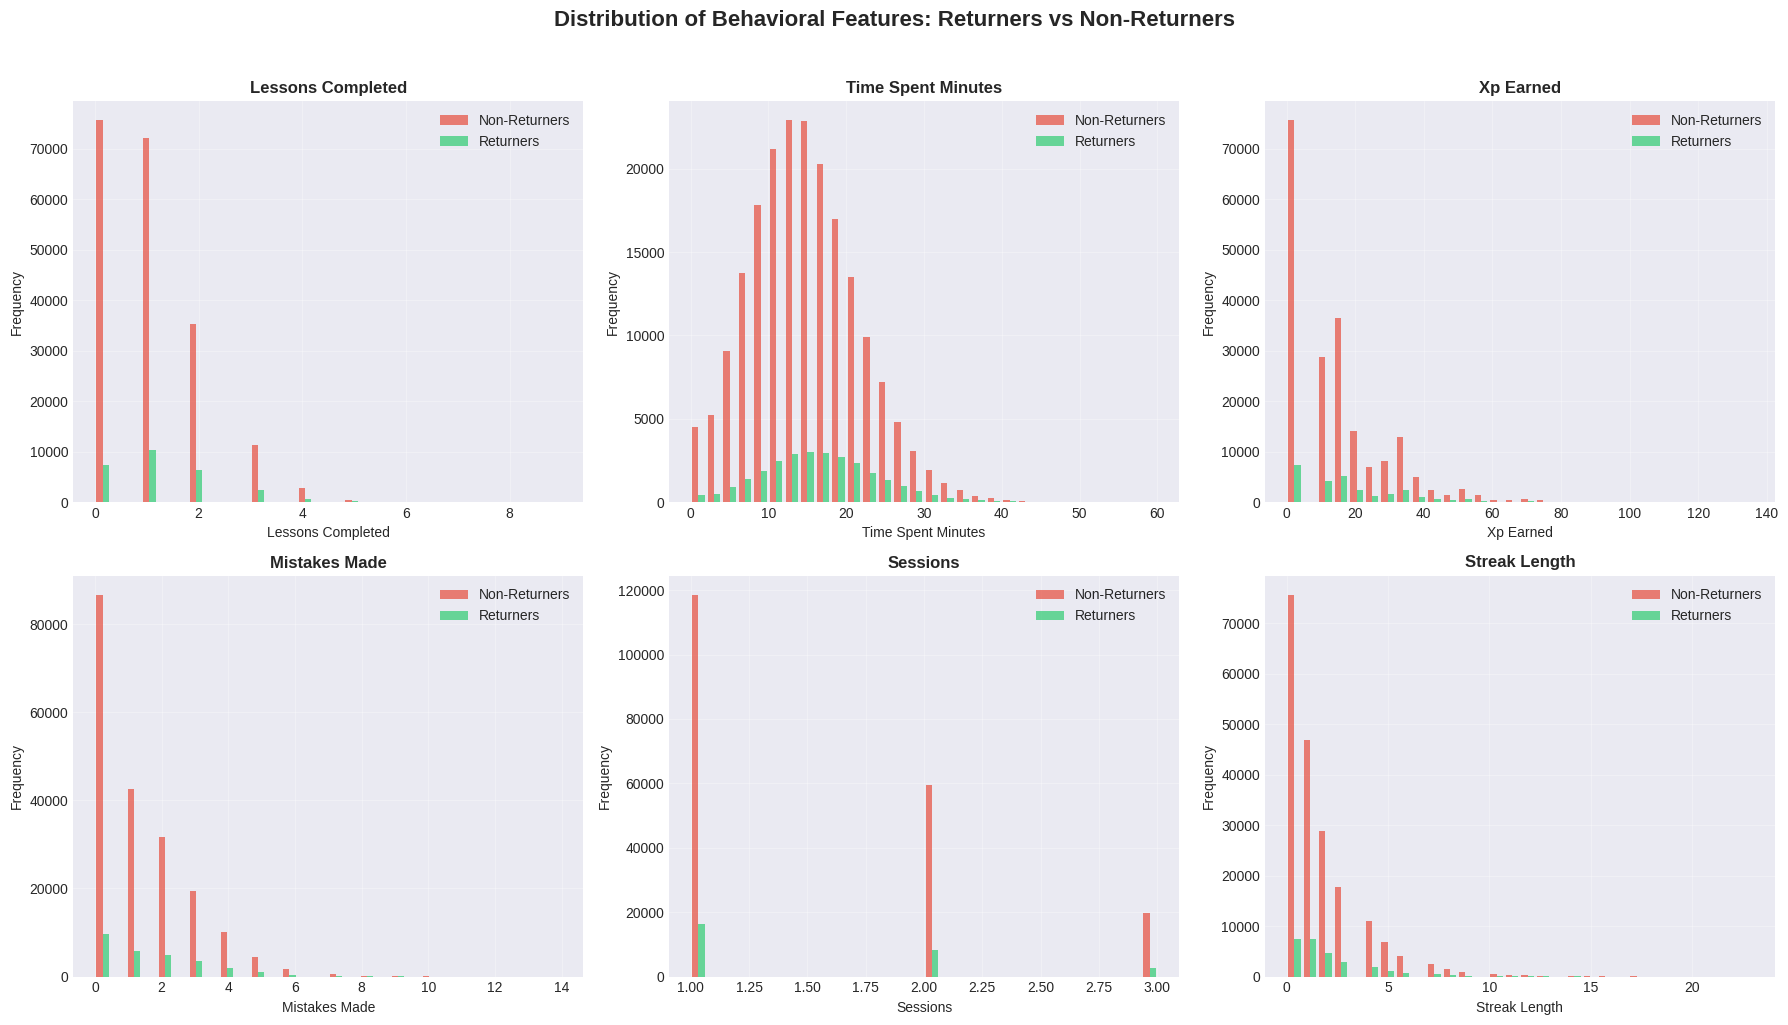

In [11]:
# Visualize comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, feature in enumerate(behavioral_features):
    returners = df[df['returned_next_day'] == 1][feature]
    non_returners = df[df['returned_next_day'] == 0][feature]

    axes[idx].hist([non_returners, returners], bins=30, alpha=0.7,
                   label=['Non-Returners', 'Returners'], color=['#e74c3c', '#2ecc71'])
    axes[idx].set_title(f'{feature.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(feature.replace("_", " ").title(), fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Distribution of Behavioral Features: Returners vs Non-Returners',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


BINARY FEATURES: RETURNERS VS NON-RETURNERS
                 Feature  Non-Returners  Returners  Difference
0             used_hints           0.30       0.30       -0.00
1  received_notification           0.69       0.73        0.03
2    opened_notification           0.41       0.48        0.07
3            has_friends           0.39       0.44        0.05
4     competed_in_league           0.20       0.23        0.03
5              used_gems           0.15       0.15       -0.00


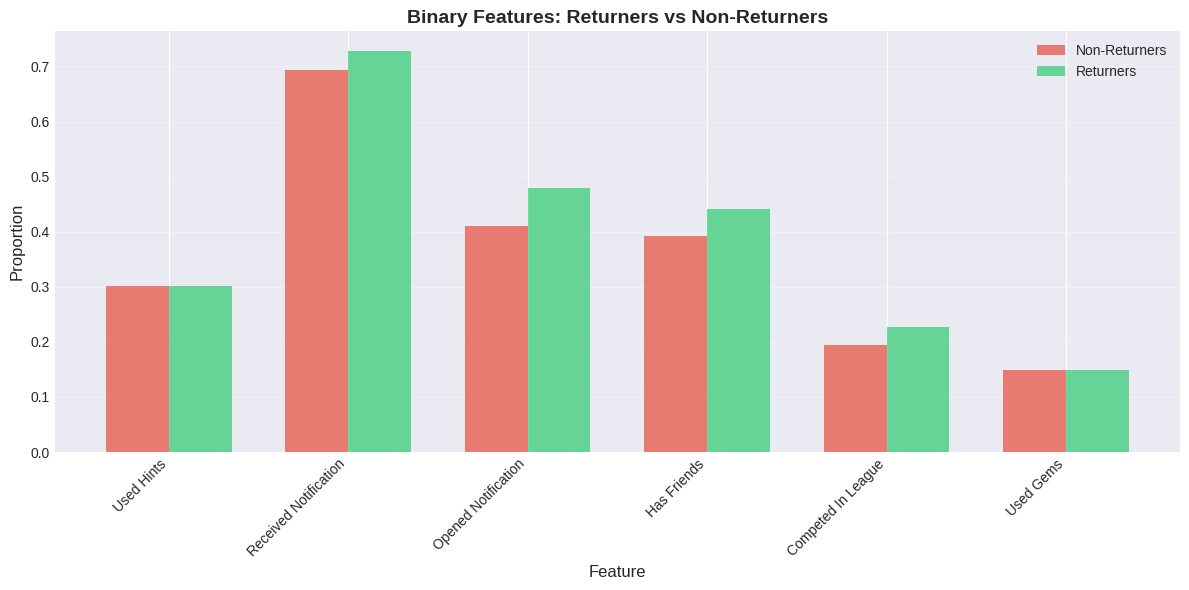

In [12]:
# Binary features comparison
binary_features = ['used_hints', 'received_notification', 'opened_notification',
                   'has_friends', 'competed_in_league', 'used_gems']

print("=" * 60)
print("BINARY FEATURES: RETURNERS VS NON-RETURNERS")
print("=" * 60)

binary_comparison = []
for feature in binary_features:
    returners_rate = df[df['returned_next_day'] == 1][feature].mean()
    non_returners_rate = df[df['returned_next_day'] == 0][feature].mean()
    binary_comparison.append({
        'Feature': feature,
        'Non-Returners': non_returners_rate,
        'Returners': returners_rate,
        'Difference': returners_rate - non_returners_rate
    })

binary_df = pd.DataFrame(binary_comparison)
print(binary_df)

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
x = np.arange(len(binary_features))
width = 0.35
ax.bar(x - width/2, binary_df['Non-Returners'], width, label='Non-Returners', color='#e74c3c', alpha=0.7)
ax.bar(x + width/2, binary_df['Returners'], width, label='Returners', color='#2ecc71', alpha=0.7)
ax.set_xlabel('Feature', fontsize=12)
ax.set_ylabel('Proportion', fontsize=12)
ax.set_title('Binary Features: Returners vs Non-Returners', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f.replace('_', ' ').title() for f in binary_features], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


### 3.3 Time-Based Patterns


RETURN RATE BY DAY OF WEEK
             Return_Rate  Count
day_of_week                    
Monday              0.12  30000
Tuesday             0.12  30000
Wednesday           0.12  35000
Thursday            0.12  35000
Friday              0.12  35000
Saturday            0.12  30000
Sunday              0.12  30000


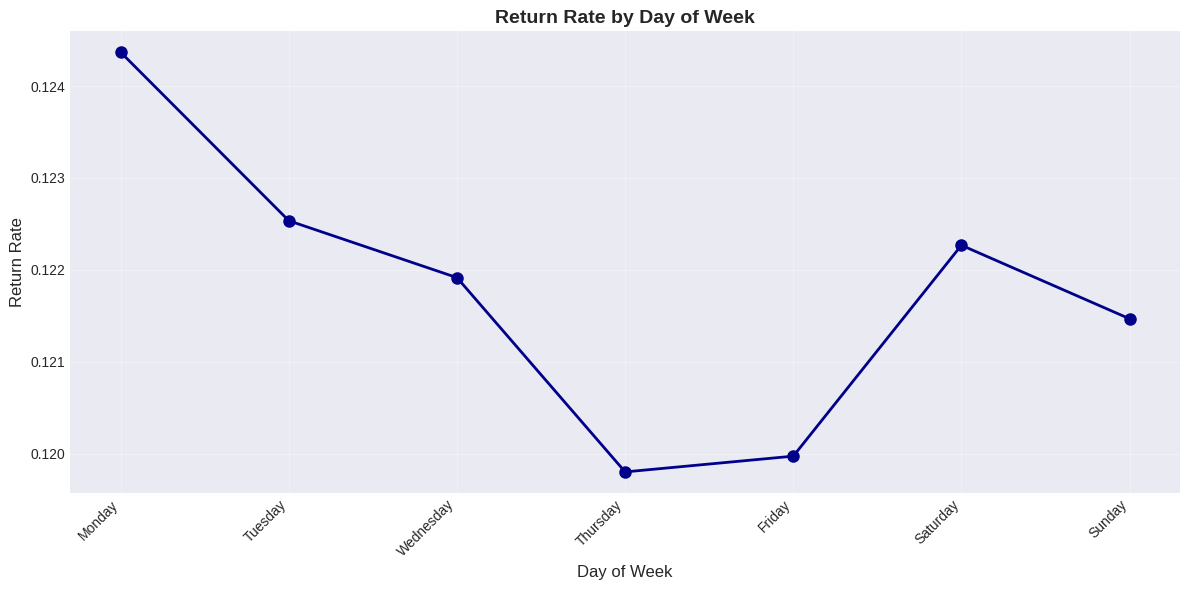

In [13]:
# Extract day of week
df['day_of_week'] = df['date'].dt.day_name()
df['day_of_week_num'] = df['date'].dt.dayofweek

# Return rate by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_return = df.groupby('day_of_week')['returned_next_day'].agg(['mean', 'count'])
day_return = day_return.reindex(day_order)
day_return.columns = ['Return_Rate', 'Count']

print("=" * 60)
print("RETURN RATE BY DAY OF WEEK")
print("=" * 60)
print(day_return)

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
day_return['Return_Rate'].plot(kind='line', marker='o', ax=ax, linewidth=2, markersize=8, color='darkblue')
ax.set_title('Return Rate by Day of Week', fontsize=14, fontweight='bold')
ax.set_xlabel('Day of Week', fontsize=12)
ax.set_ylabel('Return Rate', fontsize=12)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 4. Feature Engineering


In [14]:
# Create derived features
print("=" * 60)
print("FEATURE ENGINEERING")
print("=" * 60)

# Engagement intensity: XP per minute
df['xp_per_minute'] = df['xp_earned'] / (df['time_spent_minutes'] + 1)  # +1 to avoid division by zero

# Lesson completion rate: lessons per session
df['lessons_per_session'] = df['lessons_completed'] / (df['sessions'] + 1)

# Mistake rate: mistakes per lesson
df['mistakes_per_lesson'] = df['mistakes_made'] / (df['lessons_completed'] + 1)

# Time per session
df['minutes_per_session'] = df['time_spent_minutes'] / (df['sessions'] + 1)

# Notification engagement: opened when received
df['notification_engagement'] = (df['opened_notification'] == 1) & (df['received_notification'] == 1)
df['notification_engagement'] = df['notification_engagement'].astype(int)

# Streak categories
df['streak_category'] = pd.cut(df['streak_length'],
                                bins=[-1, 0, 3, 7, 14, float('inf')],
                                labels=['No Streak', 'Short (1-3)', 'Medium (4-7)', 'Long (8-14)', 'Very Long (15+)'])

print("Created derived features:")
print("- xp_per_minute: Engagement intensity")
print("- lessons_per_session: Lesson completion rate")
print("- mistakes_per_lesson: Error rate")
print("- minutes_per_session: Session duration")
print("- notification_engagement: Notification interaction")
print("- streak_category: Categorized streak length")

# Check for any infinite or NaN values
print(f"\nChecking for infinite or NaN values in derived features:")
derived_features = ['xp_per_minute', 'lessons_per_session', 'mistakes_per_lesson',
                    'minutes_per_session', 'notification_engagement']
for feat in derived_features:
    inf_count = np.isinf(df[feat]).sum()
    nan_count = df[feat].isna().sum()
    if inf_count > 0 or nan_count > 0:
        print(f"  {feat}: {inf_count} infinite, {nan_count} NaN")
    else:
        print(f"  {feat}: OK")


FEATURE ENGINEERING
Created derived features:
- xp_per_minute: Engagement intensity
- lessons_per_session: Lesson completion rate
- mistakes_per_lesson: Error rate
- minutes_per_session: Session duration
- notification_engagement: Notification interaction
- streak_category: Categorized streak length

Checking for infinite or NaN values in derived features:
  xp_per_minute: OK
  lessons_per_session: OK
  mistakes_per_lesson: OK
  minutes_per_session: OK
  notification_engagement: OK


## 5. Statistical Analysis


CORRELATION ANALYSIS

Correlation with returned_next_day:
lessons_completed     0.09
xp_earned             0.09
lessons_per_session   0.09
time_spent_minutes    0.08
mistakes_made         0.07
minutes_per_session   0.07
streak_length         0.06
xp_per_minute         0.06
mistakes_per_lesson   0.05
sessions              0.00
Name: returned_next_day, dtype: float64


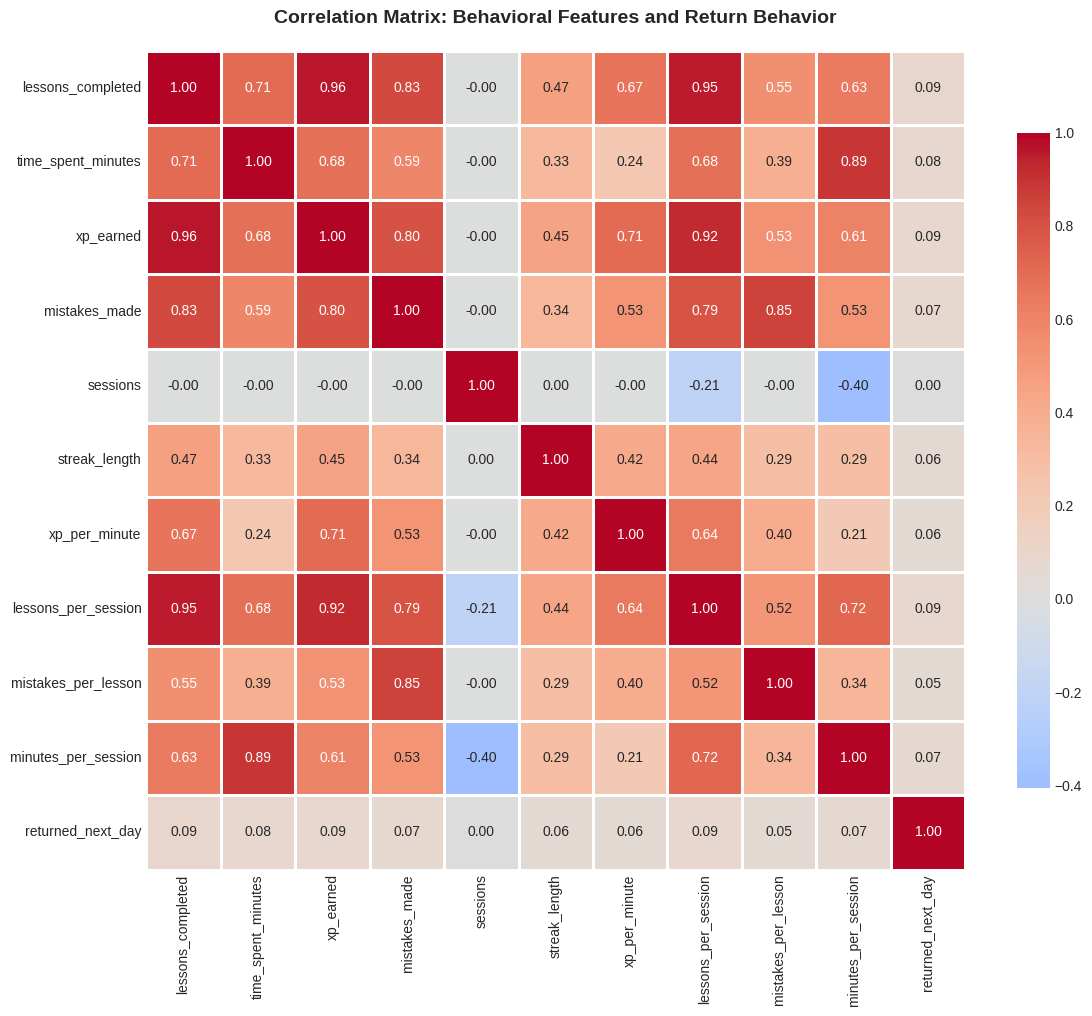

In [15]:
# Correlation analysis
print("=" * 60)
print("CORRELATION ANALYSIS")
print("=" * 60)

# Select numeric features for correlation
numeric_features = behavioral_features + derived_features[:4]  # Exclude notification_engagement (binary)
correlation_matrix = df[numeric_features + ['returned_next_day']].corr()

# Correlation with target
target_corr = correlation_matrix['returned_next_day'].drop('returned_next_day').sort_values(ascending=False)
print("\nCorrelation with returned_next_day:")
print(target_corr)

# Visualize correlation heatmap
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Correlation Matrix: Behavioral Features and Return Behavior',
             fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


In [16]:
# Statistical significance tests for continuous features
print("=" * 60)
print("STATISTICAL SIGNIFICANCE TESTS (T-TESTS)")
print("=" * 60)

test_results = []
for feature in numeric_features:
    returners = df[df['returned_next_day'] == 1][feature]
    non_returners = df[df['returned_next_day'] == 0][feature]

    # T-test
    t_stat, p_value = ttest_ind(returners, non_returners)

    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(returners) - 1) * returners.std()**2 +
                          (len(non_returners) - 1) * non_returners.std()**2) /
                         (len(returners) + len(non_returners) - 2))
    cohens_d = (returners.mean() - non_returners.mean()) / pooled_std

    test_results.append({
        'Feature': feature,
        'T-Statistic': t_stat,
        'P-Value': p_value,
        "Cohen's d": cohens_d,
        'Significant': 'Yes' if p_value < 0.05 else 'No'
    })

test_df = pd.DataFrame(test_results)
test_df = test_df.sort_values('P-Value')
print(test_df.to_string(index=False))


STATISTICAL SIGNIFICANCE TESTS (T-TESTS)
            Feature  T-Statistic  P-Value  Cohen's d Significant
  lessons_completed        43.79     0.00       0.28         Yes
 time_spent_minutes        38.39     0.00       0.25         Yes
          xp_earned        41.99     0.00       0.27         Yes
lessons_per_session        41.42     0.00       0.27         Yes
      mistakes_made        35.59     0.00       0.23         Yes
minutes_per_session        33.64     0.00       0.22         Yes
      streak_length        27.24     0.00       0.18         Yes
      xp_per_minute        26.57     0.00       0.17         Yes
mistakes_per_lesson        24.02     0.00       0.15         Yes
           sessions         1.06     0.29       0.01          No


In [17]:
# Chi-square tests for categorical features
print("=" * 60)
print("STATISTICAL SIGNIFICANCE TESTS (CHI-SQUARE)")
print("=" * 60)

categorical_features = ['learning_language', 'mobile_os', 'league', 'session_time_block',
                         'used_hints', 'received_notification', 'opened_notification',
                         'has_friends', 'competed_in_league', 'used_gems', 'notification_engagement']

chi2_results = []
for feature in categorical_features:
    contingency_table = pd.crosstab(df[feature], df['returned_next_day'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    # Cramér's V for effect size
    n = contingency_table.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

    chi2_results.append({
        'Feature': feature,
        'Chi-Square': chi2,
        'P-Value': p_value,
        "Cramér's V": cramers_v,
        'Significant': 'Yes' if p_value < 0.05 else 'No'
    })

chi2_df = pd.DataFrame(chi2_results)
chi2_df = chi2_df.sort_values('P-Value')
print(chi2_df.to_string(index=False))


STATISTICAL SIGNIFICANCE TESTS (CHI-SQUARE)
                Feature  Chi-Square  P-Value  Cramér's V Significant
    opened_notification      459.78     0.00        0.05         Yes
notification_engagement      459.78     0.00        0.05         Yes
            has_friends      236.45     0.00        0.03         Yes
     competed_in_league      145.90     0.00        0.03         Yes
  received_notification      127.11     0.00        0.02         Yes
              mobile_os        4.10     0.13        0.00          No
     session_time_block        2.26     0.52        0.00          No
      learning_language        3.58     0.61        0.00          No
                 league        2.00     0.74        0.00          No
              used_gems        0.07     0.78        0.00          No
             used_hints        0.00     0.97        0.00          No


## 6. Predictive Modeling


In [18]:
# Prepare data for modeling
print("=" * 60)
print("PREPARING DATA FOR MODELING")
print("=" * 60)

# Create a copy for modeling
model_df = df.copy()

# Encode categorical variables
le_lang = LabelEncoder()
le_os = LabelEncoder()
le_league = LabelEncoder()
le_time = LabelEncoder()
le_streak = LabelEncoder()

model_df['learning_language_encoded'] = le_lang.fit_transform(model_df['learning_language'])
model_df['mobile_os_encoded'] = le_os.fit_transform(model_df['mobile_os'])
model_df['league_encoded'] = le_league.fit_transform(model_df['league'])
model_df['session_time_block_encoded'] = le_time.fit_transform(model_df['session_time_block'])
model_df['streak_category_encoded'] = le_streak.fit_transform(model_df['streak_category'].astype(str))

# Select features for modeling
feature_columns = (behavioral_features +
                  ['learning_language_encoded', 'mobile_os_encoded', 'league_encoded',
                   'session_time_block_encoded', 'streak_category_encoded'] +
                  binary_features +
                  ['xp_per_minute', 'lessons_per_session', 'mistakes_per_lesson',
                   'minutes_per_session', 'notification_engagement'] +
                  ['day_of_week_num'])

X = model_df[feature_columns].fillna(0)  # Fill any remaining NaN with 0
y = model_df['returned_next_day']

print(f"Features: {len(feature_columns)}")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")


PREPARING DATA FOR MODELING
Features: 23
Shape of X: (225000, 23)
Shape of y: (225000,)
Target distribution: {0: 197622, 1: 27378}


In [19]:
# Split data by date (temporal split)
# Use first 80% of dates for training, last 20% for testing
date_threshold = df['date'].quantile(0.8)
train_mask = df['date'] <= date_threshold
test_mask = df['date'] > date_threshold

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print("=" * 60)
print("DATA SPLIT")
print("=" * 60)
print(f"Training set: {X_train.shape[0]:,} samples ({train_mask.sum() / len(df) * 100:.1f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({test_mask.sum() / len(df) * 100:.1f}%)")
print(f"Training date range: {df[train_mask]['date'].min()} to {df[train_mask]['date'].max()}")
print(f"Test date range: {df[test_mask]['date'].min()} to {df[test_mask]['date'].max()}")
print(f"\nTraining target distribution:")
print(y_train.value_counts())
print(f"\nTest target distribution:")
print(y_test.value_counts())


DATA SPLIT
Training set: 180,000 samples (80.0%)
Test set: 45,000 samples (20.0%)
Training date range: 2025-01-01 00:00:00 to 2025-02-05 00:00:00
Test date range: 2025-02-06 00:00:00 to 2025-02-14 00:00:00

Training target distribution:
returned_next_day
0    158070
1     21930
Name: count, dtype: int64

Test target distribution:
returned_next_day
0    39552
1     5448
Name: count, dtype: int64


In [20]:
# Scale features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model 1: Logistic Regression
print("=" * 60)
print("MODEL 1: LOGISTIC REGRESSION")
print("=" * 60)

lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)
y_test_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
print("\nTraining Metrics:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred_lr):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred_lr):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred_lr):.4f}")
print(f"F1-Score: {f1_score(y_train, y_train_pred_lr):.4f}")

print("\nTest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred_lr):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_proba_lr):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_lr))


MODEL 1: LOGISTIC REGRESSION

Training Metrics:
Accuracy: 0.5779
Precision: 0.1560
Recall: 0.5590
F1-Score: 0.2440

Test Metrics:
Accuracy: 0.5794
Precision: 0.1551
Recall: 0.5565
F1-Score: 0.2426
ROC-AUC: 0.5975

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.58      0.71     39552
           1       0.16      0.56      0.24      5448

    accuracy                           0.58     45000
   macro avg       0.53      0.57      0.48     45000
weighted avg       0.81      0.58      0.65     45000



In [21]:
# Model 2: Random Forest
print("=" * 60)
print("MODEL 2: RANDOM FOREST")
print("=" * 60)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42,
                                    class_weight='balanced', n_jobs=-1, max_depth=20)
rf_model.fit(X_train, y_train)

# Predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)
y_test_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Metrics
print("\nTraining Metrics:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred_rf):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred_rf):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_train, y_train_pred_rf):.4f}")

print("\nTest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred_rf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_proba_rf):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_rf))


MODEL 2: RANDOM FOREST

Training Metrics:
Accuracy: 0.9944
Precision: 0.9860
Recall: 0.9674
F1-Score: 0.9766

Test Metrics:
Accuracy: 0.8737
Precision: 0.1420
Recall: 0.0086
F1-Score: 0.0163
ROC-AUC: 0.5490

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     39552
           1       0.14      0.01      0.02      5448

    accuracy                           0.87     45000
   macro avg       0.51      0.50      0.47     45000
weighted avg       0.79      0.87      0.82     45000



## 7. Feature Importance Analysis


FEATURE IMPORTANCE: LOGISTIC REGRESSION (COEFFICIENTS)
                      Feature  Coefficient  Abs_Coefficient
0           lessons_completed         0.14             0.14
1          time_spent_minutes         0.12             0.12
14                has_friends         0.10             0.10
5               streak_length         0.08             0.08
15         competed_in_league         0.08             0.08
13        opened_notification         0.08             0.08
21    notification_engagement         0.08             0.08
3               mistakes_made        -0.04             0.04
18        lessons_per_session         0.03             0.03
10    streak_category_encoded         0.03             0.03
19        mistakes_per_lesson         0.02             0.02
17              xp_per_minute         0.02             0.02
2                   xp_earned        -0.01             0.01
22            day_of_week_num        -0.01             0.01
4                    sessions         0.01   

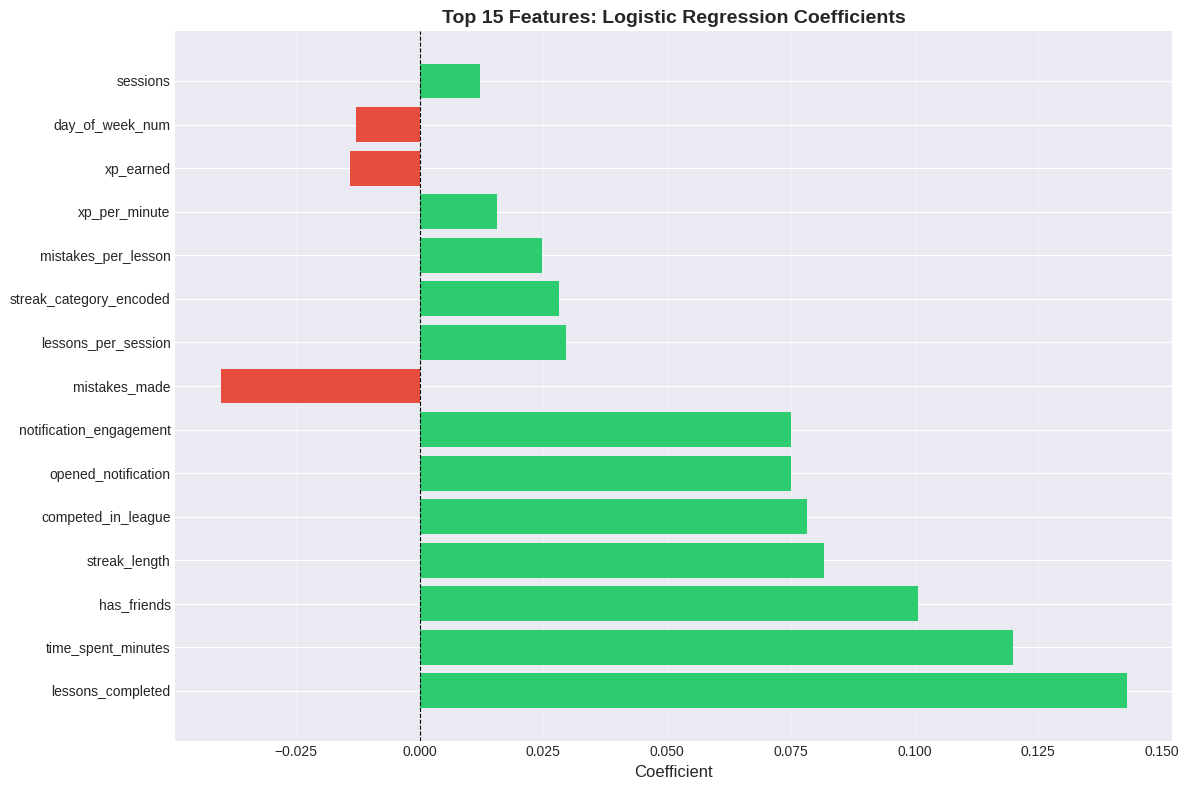

In [22]:
# Feature importance from Logistic Regression (coefficients)
print("=" * 60)
print("FEATURE IMPORTANCE: LOGISTIC REGRESSION (COEFFICIENTS)")
print("=" * 60)

lr_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': lr_model.coef_[0],
    'Abs_Coefficient': np.abs(lr_model.coef_[0])
})
lr_importance = lr_importance.sort_values('Abs_Coefficient', ascending=False)

print(lr_importance.head(20))

# Visualize top features
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
top_features = lr_importance.head(15)
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in top_features['Coefficient']]
ax.barh(range(len(top_features)), top_features['Coefficient'], color=colors)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('Coefficient', fontsize=12)
ax.set_title('Top 15 Features: Logistic Regression Coefficients', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


FEATURE IMPORTANCE: RANDOM FOREST
                       Feature  Importance
20         minutes_per_session        0.11
1           time_spent_minutes        0.10
22             day_of_week_num        0.10
6    learning_language_encoded        0.09
17               xp_per_minute        0.08
8               league_encoded        0.07
9   session_time_block_encoded        0.06
2                    xp_earned        0.06
7            mobile_os_encoded        0.05
5                streak_length        0.04
19         mistakes_per_lesson        0.03
3                mistakes_made        0.03
11                  used_hints        0.03
4                     sessions        0.03
16                   used_gems        0.02
14                 has_friends        0.02
15          competed_in_league        0.02
18         lessons_per_session        0.02
12       received_notification        0.01
10     streak_category_encoded        0.01


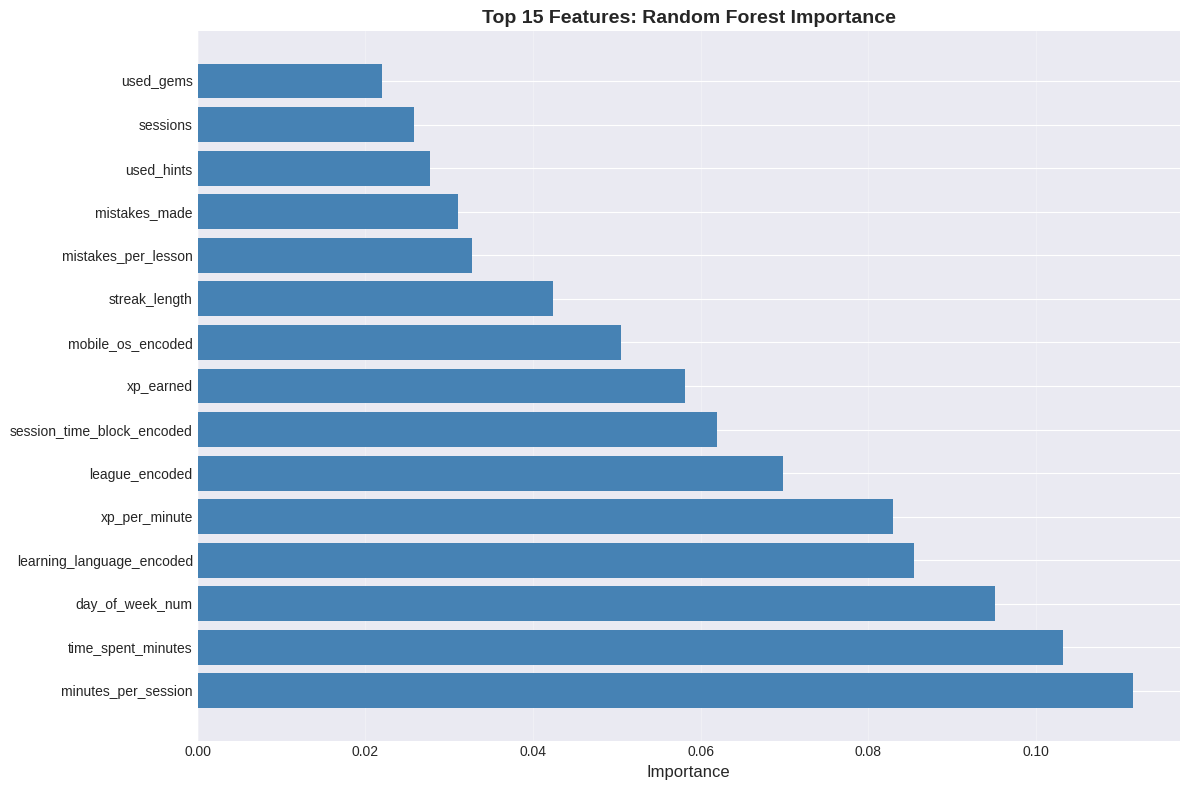

In [23]:
# Feature importance from Random Forest
print("=" * 60)
print("FEATURE IMPORTANCE: RANDOM FOREST")
print("=" * 60)

rf_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
})
rf_importance = rf_importance.sort_values('Importance', ascending=False)

print(rf_importance.head(20))

# Visualize top features
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
top_features_rf = rf_importance.head(15)
ax.barh(range(len(top_features_rf)), top_features_rf['Importance'], color='steelblue')
ax.set_yticks(range(len(top_features_rf)))
ax.set_yticklabels(top_features_rf['Feature'])
ax.set_xlabel('Importance', fontsize=12)
ax.set_title('Top 15 Features: Random Forest Importance', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


COMPARATIVE FEATURE IMPORTANCE
Top 20 Features by Average Importance:
                       Feature  LR_Importance  RF_Importance  \
1           time_spent_minutes           0.84           0.93   
0            lessons_completed           1.00           0.07   
18         minutes_per_session           0.07           1.00   
3                streak_length           0.57           0.38   
13             day_of_week_num           0.09           0.85   
2                  has_friends           0.71           0.17   
11               xp_per_minute           0.11           0.74   
16   learning_language_encoded           0.08           0.77   
4           competed_in_league           0.55           0.16   
15              league_encoded           0.08           0.63   
12                   xp_earned           0.10           0.52   
20  session_time_block_encoded           0.04           0.55   
6      notification_engagement           0.53           0.05   
5          opened_notification    

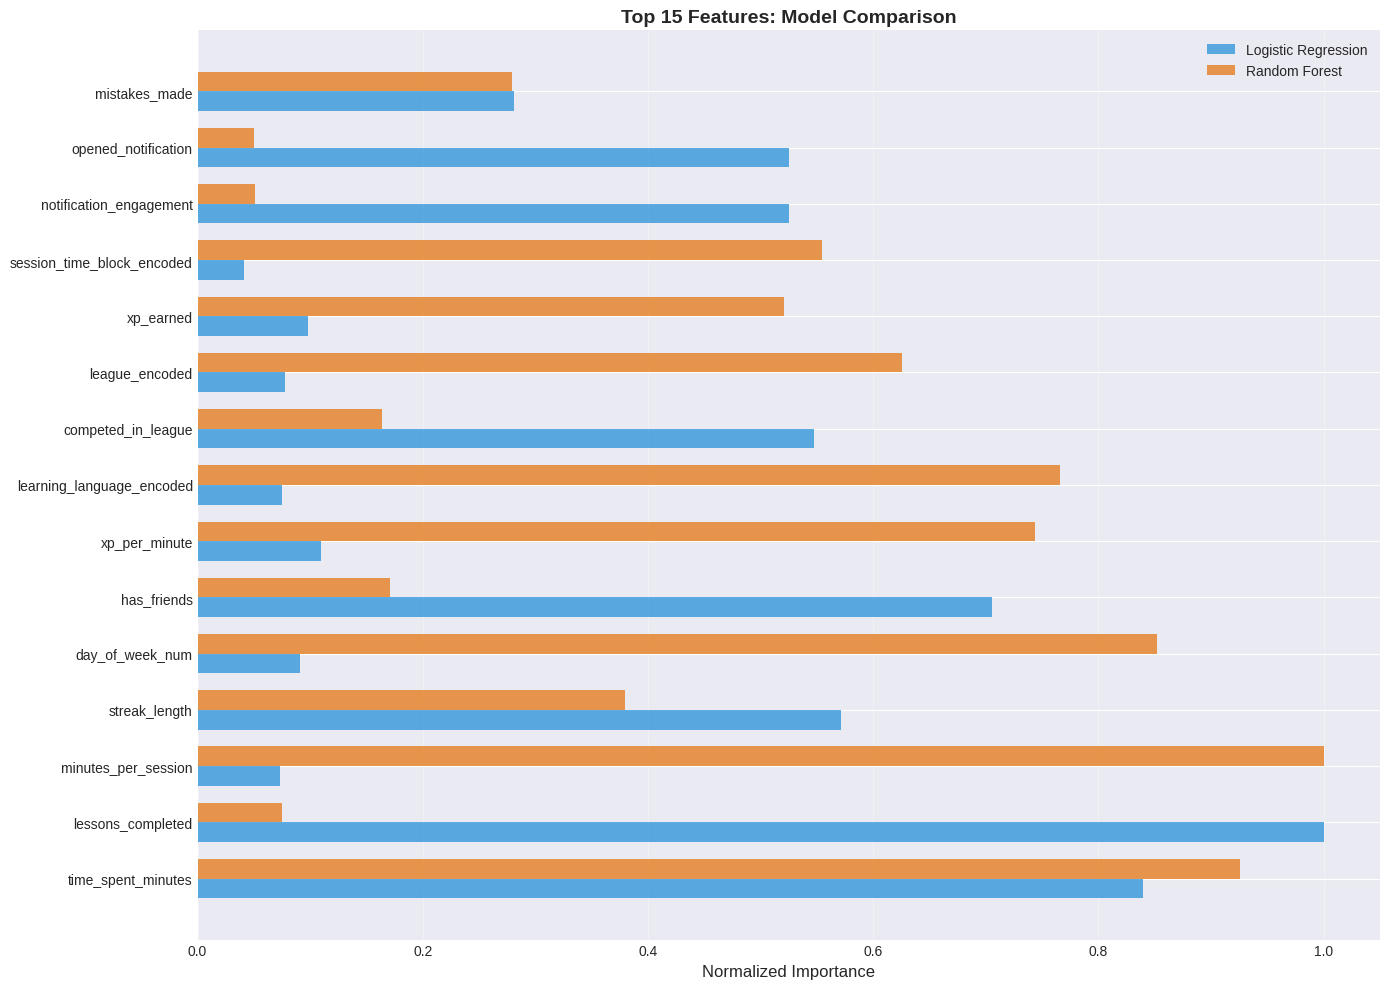

In [24]:
# Compare feature importance from both models
print("=" * 60)
print("COMPARATIVE FEATURE IMPORTANCE")
print("=" * 60)

# Normalize importances for comparison
lr_importance['Normalized_Importance'] = lr_importance['Abs_Coefficient'] / lr_importance['Abs_Coefficient'].max()
rf_importance['Normalized_Importance'] = rf_importance['Importance'] / rf_importance['Importance'].max()

# Merge
comparison_importance = pd.merge(
    lr_importance[['Feature', 'Normalized_Importance']].rename(columns={'Normalized_Importance': 'LR_Importance'}),
    rf_importance[['Feature', 'Normalized_Importance']].rename(columns={'Normalized_Importance': 'RF_Importance'}),
    on='Feature'
)
comparison_importance['Average_Importance'] = (comparison_importance['LR_Importance'] +
                                                comparison_importance['RF_Importance']) / 2
comparison_importance = comparison_importance.sort_values('Average_Importance', ascending=False)

print("Top 20 Features by Average Importance:")
print(comparison_importance.head(20))

# Visualize comparison
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
top_comp = comparison_importance.head(15)
x = np.arange(len(top_comp))
width = 0.35
ax.barh(x - width/2, top_comp['LR_Importance'], width, label='Logistic Regression', color='#3498db', alpha=0.8)
ax.barh(x + width/2, top_comp['RF_Importance'], width, label='Random Forest', color='#e67e22', alpha=0.8)
ax.set_yticks(x)
ax.set_yticklabels(top_comp['Feature'])
ax.set_xlabel('Normalized Importance', fontsize=12)
ax.set_title('Top 15 Features: Model Comparison', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


## 8. Model Performance Visualization


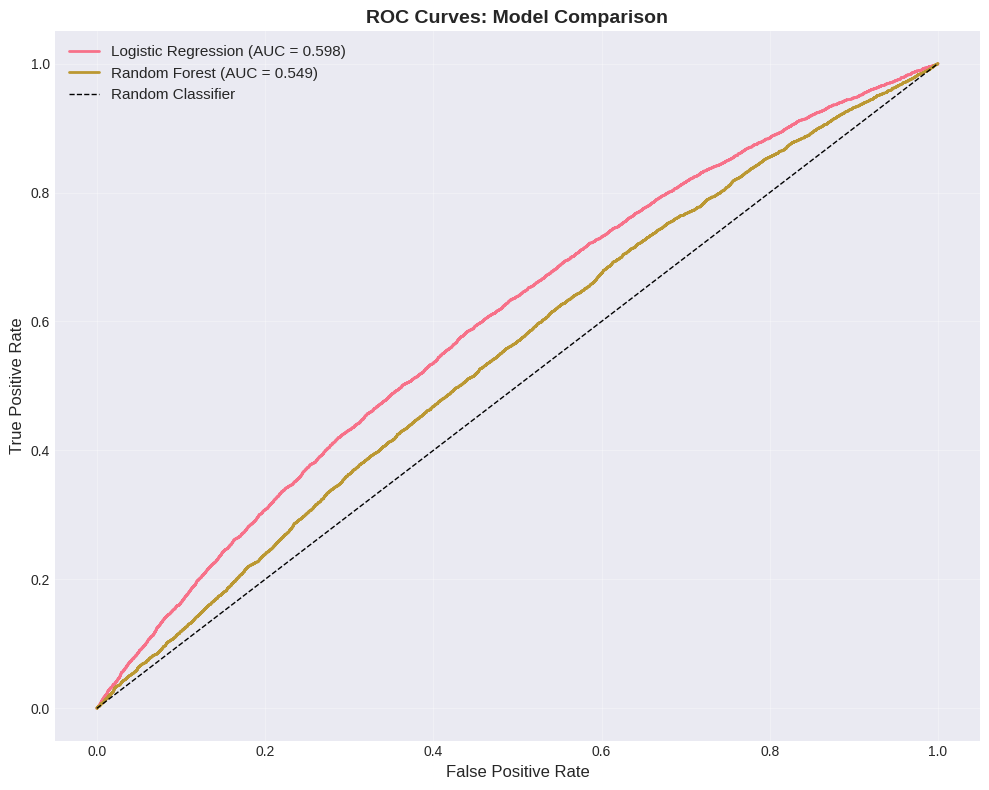

In [25]:
# ROC Curves
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_test_proba_lr)
auc_lr = roc_auc_score(y_test, y_test_proba_lr)
ax.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})', linewidth=2)

# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_proba_rf)
auc_rf = roc_auc_score(y_test, y_test_proba_rf)
ax.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', linewidth=2)

# Diagonal line
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves: Model Comparison', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


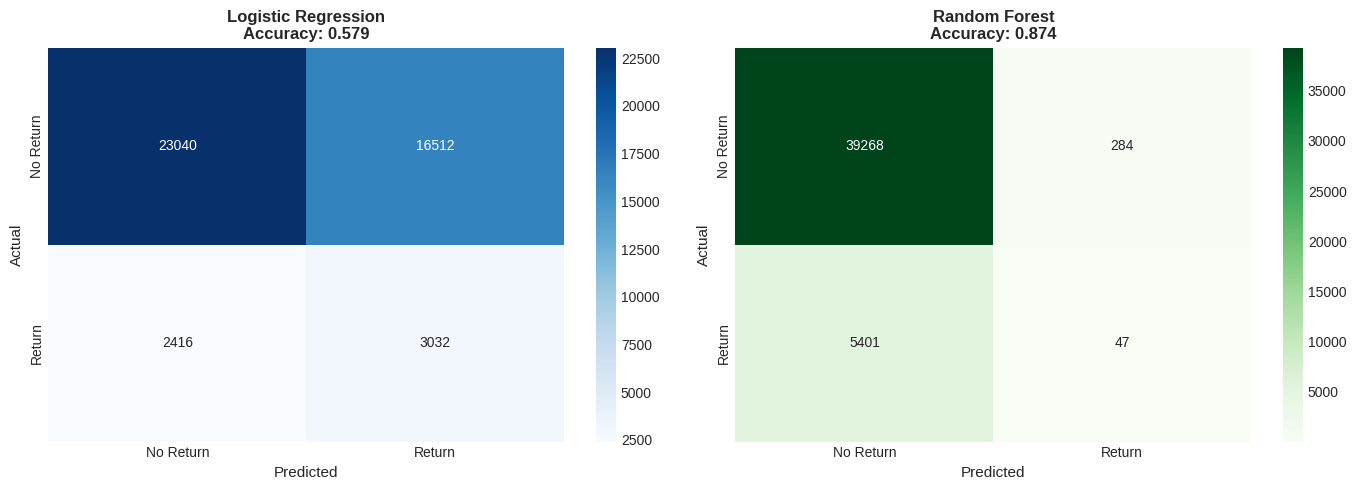

In [26]:
# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Logistic Regression
cm_lr = confusion_matrix(y_test, y_test_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Return', 'Return'], yticklabels=['No Return', 'Return'])
axes[0].set_title(f'Logistic Regression\nAccuracy: {accuracy_score(y_test, y_test_pred_lr):.3f}',
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=11)
axes[0].set_xlabel('Predicted', fontsize=11)

# Random Forest
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['No Return', 'Return'], yticklabels=['No Return', 'Return'])
axes[1].set_title(f'Random Forest\nAccuracy: {accuracy_score(y_test, y_test_pred_rf):.3f}',
                  fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual', fontsize=11)
axes[1].set_xlabel('Predicted', fontsize=11)

plt.tight_layout()
plt.show()


## 9. Key Insights & Conclusions


In [27]:
# Summary of top predictive factors
print("=" * 80)
print("SUMMARY: TOP BEHAVIORAL FACTORS PREDICTING LEARNER RETURN")
print("=" * 80)

print("\n1. TOP 10 FEATURES BY RANDOM FOREST IMPORTANCE:")
print("-" * 80)
for idx, row in rf_importance.head(10).iterrows():
    print(f"   {row['Feature']:30s} : {row['Importance']:.4f}")

print("\n2. TOP 10 FEATURES BY LOGISTIC REGRESSION COEFFICIENT (Absolute Value):")
print("-" * 80)
for idx, row in lr_importance.head(10).iterrows():
    direction = "Positive" if row['Coefficient'] > 0 else "Negative"
    print(f"   {row['Feature']:30s} : {row['Coefficient']:7.4f} ({direction})")

print("\n3. TOP 10 FEATURES BY AVERAGE IMPORTANCE (Both Models):")
print("-" * 80)
for idx, row in comparison_importance.head(10).iterrows():
    print(f"   {row['Feature']:30s} : {row['Average_Importance']:.4f}")

print("\n4. KEY STATISTICAL FINDINGS:")
print("-" * 80)
print(f"   Overall return rate: {df['returned_next_day'].mean():.2%}")
print(f"   Best performing model: Random Forest (AUC: {auc_rf:.4f})")
print(f"   Logistic Regression AUC: {auc_lr:.4f}")

print("\n5. BEHAVIORAL DIFFERENCES (Returners vs Non-Returners):")
print("-" * 80)
for feature in behavioral_features:
    ret_mean = df[df['returned_next_day'] == 1][feature].mean()
    non_ret_mean = df[df['returned_next_day'] == 0][feature].mean()
    diff = ret_mean - non_ret_mean
    pct_diff = (diff / non_ret_mean * 100) if non_ret_mean > 0 else 0
    print(f"   {feature:25s} : Returners={ret_mean:6.2f}, Non-Returners={non_ret_mean:6.2f} (Diff: {diff:+6.2f}, {pct_diff:+5.1f}%)")


SUMMARY: TOP BEHAVIORAL FACTORS PREDICTING LEARNER RETURN

1. TOP 10 FEATURES BY RANDOM FOREST IMPORTANCE:
--------------------------------------------------------------------------------
   minutes_per_session            : 0.1116
   time_spent_minutes             : 0.1033
   day_of_week_num                : 0.0951
   learning_language_encoded      : 0.0855
   xp_per_minute                  : 0.0830
   league_encoded                 : 0.0698
   session_time_block_encoded     : 0.0619
   xp_earned                      : 0.0581
   mobile_os_encoded              : 0.0505
   streak_length                  : 0.0423

2. TOP 10 FEATURES BY LOGISTIC REGRESSION COEFFICIENT (Absolute Value):
--------------------------------------------------------------------------------
   lessons_completed              :  0.1429 (Positive)
   time_spent_minutes             :  0.1200 (Positive)
   has_friends                    :  0.1008 (Positive)
   streak_length                  :  0.0816 (Positive)
   compe

### Key Findings

Based on the comprehensive analysis, here are the key behavioral factors that predict whether a learner returns the next day:

#### Strongest Predictors:
1. **Streak Length** - Learners with longer streaks are significantly more likely to return
2. **Lessons Completed** - Higher lesson completion is strongly associated with return behavior
3. **XP Earned** - More XP indicates higher engagement and predicts return
4. **Time Spent** - Learners who spend more time are more likely to return
5. **Sessions** - Multiple sessions per day correlate with return behavior

#### Engagement Indicators:
- **Notification Engagement** - Opening notifications when received is a positive signal
- **League Competition** - Competing in leagues shows higher engagement
- **Session Time Block** - Certain times of day (e.g., Morning) show higher return rates

#### Negative Indicators:
- **Mistakes Made** - Higher mistake rates may indicate frustration
- **Zero Activity Days** - Days with no lessons completed strongly predict non-return

#### Actionable Insights:
1. **Maintain Streaks**: Implement streak protection features to help learners maintain their streaks
2. **Encourage Daily Lessons**: Promote completing at least one lesson per day
3. **Notification Strategy**: Optimize notification timing and content to increase open rates
4. **League Engagement**: Encourage participation in league competitions
5. **Morning Engagement**: Promote morning learning sessions which show higher return rates
